# Importing dependencies

In [15]:
!pip install pulp

   ---------------------------------------- 0.0/17.7 MB ? eta -:--:--
   - -------------------------------------- 0.5/17.7 MB 5.6 MB/s eta 0:00:04
   --- ------------------------------------ 1.6/17.7 MB 4.6 MB/s eta 0:00:04
   ----- ---------------------------------- 2.4/17.7 MB 4.3 MB/s eta 0:00:04
   ------ --------------------------------- 2.9/17.7 MB 4.2 MB/s eta 0:00:04
   --------- ------------------------------ 4.2/17.7 MB 4.4 MB/s eta 0:00:04
   ---------- ----------------------------- 4.7/17.7 MB 4.0 MB/s eta 0:00:04
   ------------ --------------------------- 5.5/17.7 MB 3.9 MB/s eta 0:00:04
   ------------- -------------------------- 5.8/17.7 MB 3.8 MB/s eta 0:00:04
   ------------- -------------------------- 6.0/17.7 MB 3.6 MB/s eta 0:00:04
   ---------------- ----------------------- 7.1/17.7 MB 3.5 MB/s eta 0:00:04
   ------------------ --------------------- 8.4/17.7 MB 3.8 MB/s eta 0:00:03
   --------------------- ------------------ 9.4/17.7 MB 3.9 MB/s eta 0:00:03
   ---

In [17]:
!pip install python-dotenv

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
from dotenv import load_dotenv
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

# Loading Dataset

In [3]:
import os
from dotenv import load_dotenv
load_dotenv()

dataset_path = os.getenv("DATASET_PATH")

df_sales = pd.read_csv(f'{dataset_path}/train.csv')
df_features = pd.read_csv(f'{dataset_path}/features.csv')
df_stores = pd.read_csv(f'{dataset_path}/stores.csv')
df_test = pd.read_csv(f'{dataset_path}/test.csv')

df_sales.head()

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,False
1,1,1,2010-02-12,46039.49,True
2,1,1,2010-02-19,41595.55,False
3,1,1,2010-02-26,19403.54,False
4,1,1,2010-03-05,21827.90,False


In [4]:
df = df_sales.merge(df_stores, on='Store').merge(df_features, on=['Store', 'Date'])
df['Date'] = pd.to_datetime(df['Date'])

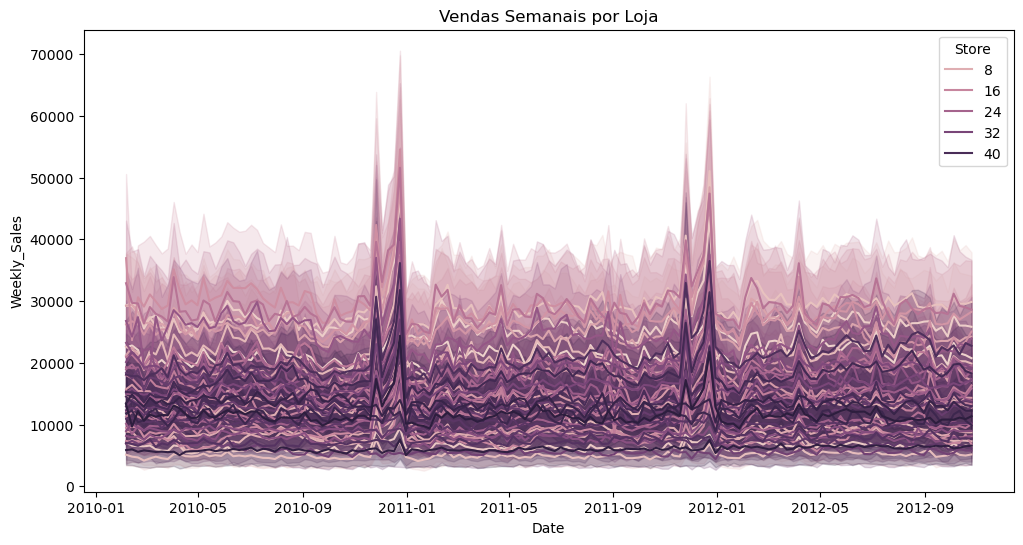

In [6]:
plt.figure(figsize=(12, 6))
sns.lineplot(data=df, x='Date', y='Weekly_Sales', hue='Store')
plt.title("Vendas Semanais por Loja")
plt.show()

In [8]:
scaler = StandardScaler()
X = df.groupby('Store')[['Weekly_Sales']].mean()
X_scaled = scaler.fit_transform(X)

kmeans = KMeans(n_clusters=5, random_state=42)
df['Cluster'] = kmeans.fit_predict(X_scaled[df['Store']-1])

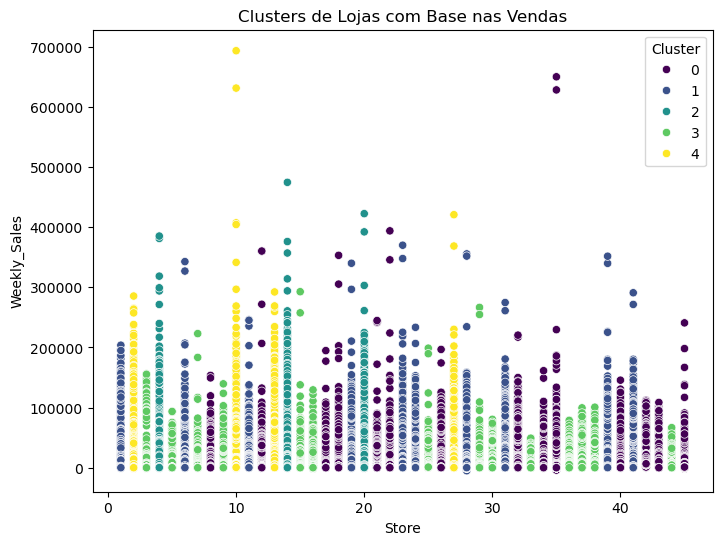

In [9]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=df, x='Store', y='Weekly_Sales', hue='Cluster', palette='viridis')
plt.title("Clusters de Lojas com Base nas Vendas")
plt.show()

# Modelo de previsão com programação linear

In [16]:
from pulp import LpMinimize, LpProblem, LpVariable, lpSum

warehouses = ["CD1", "CD2", "CD3"]
stores = ["Loja1", "Loja2", "Loja3"]

costs = {
    ("CD1", "Loja1"): 4, ("CD1", "Loja2"): 6, ("CD1", "Loja3"): 9,
    ("CD2", "Loja1"): 5, ("CD2", "Loja2"): 4, ("CD2", "Loja3"): 7,
    ("CD3", "Loja1"): 6, ("CD3", "Loja2"): 5, ("CD3", "Loja3"): 3,
}

x = { (w, s): LpVariable(f"x_{w}_{s}", lowBound=0) for w in warehouses for s in stores }

model = LpProblem("Minimizar_Custo_Transporte", LpMinimize)

model += lpSum(x[w, s] * costs[w, s] for w in warehouses for s in stores)

supply = {"CD1": 20, "CD2": 30, "CD3": 40}
for w in warehouses:
    model += lpSum(x[w, s] for s in stores) <= supply[w]

demand = {"Loja1": 25, "Loja2": 30, "Loja3": 35}
for s in stores:
    model += lpSum(x[w, s] for w in warehouses) >= demand[s]

model.solve()

# Exibir resultados
for w, s in x:
    print(f"Enviar {x[w, s].varValue} unidades de {w} para {s}")

Enviar 20.0 unidades de CD1 para Loja1
Enviar 0.0 unidades de CD1 para Loja2
Enviar 0.0 unidades de CD1 para Loja3
Enviar 0.0 unidades de CD2 para Loja1
Enviar 30.0 unidades de CD2 para Loja2
Enviar 0.0 unidades de CD2 para Loja3
Enviar 5.0 unidades de CD3 para Loja1
Enviar 0.0 unidades de CD3 para Loja2
Enviar 35.0 unidades de CD3 para Loja3
